In [4]:
%matplotlib inline

In [5]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils 
from torch.autograd import Variable

import copy

In [6]:
CONTENT_IMG = "dancing.jpg"
STYLE_IMG = "picasso.jpg"

STEPS = 500

IMSIZE = 512 if torch.cuda.is_available() else 128

MEAN=[0.485, 0.456, 0.406]
STD=[0.229, 0.224, 0.225]

CNTWEIGHT = 1
STLWEIGHT = 1000

#etc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = models.vgg19(pretrained=True).features.to(device).eval() #평가판을 사용해야 모델에 영향을 안주고 할 수 있다...?

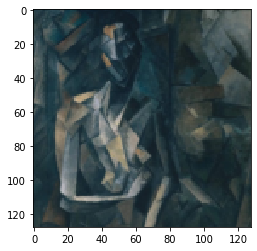

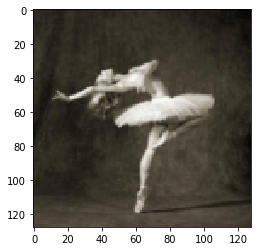

In [7]:
#Images
convert = transforms.Compose([ #데이터셋을 가져올 때 형태를 변환해주는 부분.
    transforms.Resize(IMSIZE), #이미지 크기 변환
    transforms.ToTensor() #pytorch에서 사용하기 위한 tensor자료구조로 변환
])
reconvert = transforms.ToPILImage()

def imageLoad(image_name):  #이미지를 텐서로 전환해 모델에 
    img = Image.open(image_name)
    img = convert(img).unsqueeze(0).clone()
    return img.to(device, torch.float)

def showImage(tensor): #결과를 보여주기 위한 작업
    image = tensor.cpu().clone() #원본이미지 손상 방지용 clone
    image = image.squeeze(0) #delete fake dimension
    image = reconvert(image)
    plt.imshow(image)
    
style_img = imageLoad(STYLE_IMG) 
content_img = imageLoad(CONTENT_IMG)
plt.figure()
showImage(style_img)
plt.figure()
showImage(content_img)

In [8]:
input_img = torch.randn(content_img.data.size(), requires_grad=True,device=device)

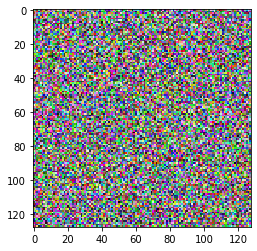

In [9]:
plt.figure()
showImage(input_img)

In [10]:
def ContentLoss(y_pred,y):
    loss = F.mse_loss(y_pred,y)/2.0
    return loss

def gramMatrix(input):
    b, c, h, w = input.size() #batch size(1), chanel, height, width
    features = input.view(b*c, h*w) 
    gram = torch.mm(features, features.t())
    return gram

def StyleLoss(y_pred, y,layer):
    
    N = layer.out_channels 
    #the number of feature maps at layer L -> 채널 수
    M = layer.kernel_size[0] 
    #height * width of feature maps at layer L
    
    A = gramMatrix(y).detach() 
    #original
    G = gramMatrix(y_pred).detach() 
    #generated
    
    #E = F.mse_loss(G,A)
    E = (1/4* N*N*M*M) * F.mse_loss(G,A) 
    return E  

In [11]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [17]:
content_layers = ['conv_10']
style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']
w = 0.2 #스타일 각 계층에 대한 가중치 = 1/5 

In [13]:
def get_losses(vgg, style_img, content_img, input_img):
    
    normalization = Normalization(MEAN, STD).to(device)
    
    content_losses = []
    style_losses = []
    i=0
    for layer in vgg.children():  
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
            
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
            #layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
            
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    
        
        if name in content_layers:
            tmp_model = vgg[:(i+1)]
            # add content loss:
            target = tmp_model(content_img).detach()#P
            ans = tmp_model(input_img).detach() #F
            target.requires_grad_(True)
            ans.requires_grad_(True)
            
            content_loss = ContentLoss(target, ans)
            content_losses.append(content_loss)
            
        if name in style_layers:
            tmp_model = vgg[:(i+1)]
            # add style loss:
            target_feature = tmp_model(style_img).detach() #A
            ans_feature = tmp_model(input_img).detach() #G
            target_feature.requires_grad_(True)
            ans_feature.requires_grad_(True)
            
            style_loss = StyleLoss(target_feature, ans_feature, layer)
            style_losses.append(style_loss)
            
    return style_losses, content_losses

In [14]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [15]:
def makeOutput(vgg, content_img, style_img, input_img):
    
    style_losses, content_losses = get_losses(vgg,
                                              style_img, content_img, input_img)
    optimizer = get_input_optimizer(input_img)
    
    run = [0]
    print('Optimizing..')
    while run[0] <= STEPS:
        
        def closure():
            # 입력 이미지의 업데이트된 값들을 보정합니다
            input_img.data.clamp_(0, 1)
        
            optimizer.zero_grad()
            vgg(input_img)

            style_total = 0
            content_total = 0
            
            for i in content_losses:
                content_total += i
            for i in style_losses:
                style_total += i #*w
                
            total_loss = style_total * STLWEIGHT + content_total * CNTWEIGHT
            print("total:",total_loss)
            
            total_loss.backward(retain_graph=True) 
            ##retrain_graph -> 그래프의 어떤 부분에서 백워드를 2번 하려면 
            #첫 번째 단계에서 true를 전달해 줄 필요가 있다.
    

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_total.item(), content_total.item()))
                print()
            return style_total + content_total
        
        
        optimizer.step(closure)
        
    input_img.data.clamp_(0, 1)
    
    return input_img

Optimizing..
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<Ad

total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)


total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)


total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
total: tensor(6.3081e+17, grad_fn=<AddBackward0>)
run [500]:
Style Loss : 630808624758784.000000 Content Loss: 26.456711

total: tensor(6.3081e+17, gr

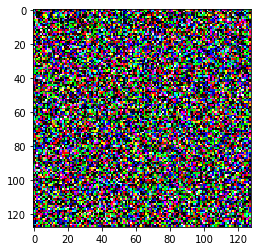

In [18]:
result_img = makeOutput(vgg, content_img, style_img, input_img)

plt.figure()
showImage(result_img)